# Análise da Perda de Funcionário

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from scipy.stats import kendalltau
import lightgbm as lgb
from statsmodels.stats.weightstats import ztest
import glob
import os
from typing import Dict, List, Tuple, Any
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme(style='darkgrid')
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12, 8)

## Funcionalidades Implementadas

In [127]:
def binary_cumulative(data_frame: pd.DataFrame, variavel_explicativa: str,
 variavel_alvo: str, sorted: bool = False) -> Dict[Any, List]:
  
  """
  Função que calcula, para uma variável alvo binária, a quantidade de ocorrências de \n
  cada valor da variável alvo, em cada valor da variável explicativa.


  Parametros
  ----------
  data_frame : pd.DataFrame
      DataFrame com as variáveis explicativas e alvo.
  variavel_explicativa : str
      Nome da variável explicativa.
  variavel_alvo : str
      Nome da variável alvo.
  sorted : bool, optional
      Se True, retorna uma lista ordenada.
  
  Retorno
  -------
  Retorna um dicionário com as ocorrências dos valores da variável alvo \n
  para cada valor da variável explicativa.

  Exemplo
  -------
  >>> binary_cumulative(data_frame, "Attrition", "YearsWithCurrManager")
  >>> {5: [27, 4],
  >>> 7: [185, 31],
  >>> 0: [178, 85],
  >>> 2: [294, 50],
  >>> 6: [25, 4],
  >>> 8: [97, 10],
  >>> 3: [123, 19],
  >>> 11: [21, 1],
  >>> 17: [7, 0],
  >>> 1: [65, 11],
  >>> 4: [87, 11],
  >>> 12: [18, 0],
  >>> 9: [58, 6],
  >>> 10: [24, 3],
  >>> 15: [5, 0],
  >>> 13: [14, 0],
  >>> 16: [2, 0],
  >>> 14: [3, 2]}

  """


  # ------------------------------------------------------------ #
  
  # Inicializando o dicionário que armazenará os resultados
  dict_result = {}

  # ------------------------------------------------------------ #

  # Armazenando em um array os valores únicos da variavel explicativa
  if sorted:
    data_feature_unique_values = np.sort(data_frame[variavel_explicativa].unique())
  else:
    data_feature_unique_values = data_frame[variavel_explicativa].unique()

  # ------------------------------------------------------------ #

  # Armazenando os valores únicos da variavel alvo
  binary_target = np.sort(data_frame[variavel_alvo].unique())

    # Criando uma tupla para abrigar os valores da variável alvo
  binary_values_target = (binary_target[0], binary_target[1])

  # ------------------------------------------------------------ #


  # Loop para calcular a ocorrência dos valores binários da variável alvo, em cada valor da variável explicativa

  for i in data_feature_unique_values:
    dict_result[i] = [data_frame.loc[(data_frame[variavel_alvo]==binary_values_target[0]) & (data_frame[variavel_explicativa]==i)].__len__(),
                      data_frame.loc[(data_frame[variavel_alvo]==binary_values_target[1]) & (data_frame[variavel_explicativa]==i)].__len__()] 

  # ------------------------------------------------------------ #

  # Retornando um dicionário com os resultados {variável explicativa: (ocorrencias da variavel alvo 1, ocorrencias da variavel alvo 2)}
  return dict_result


def to_plot_cumulative(data_frame: pd.DataFrame, variavel_explicativa: str, 
variavel_alvo: str, index: int) -> Tuple[float]:
  """
  Função que gera dados prontos para plot, considerando o agregado dos valores binários\n
  para cada valor da variável explicativa.

    Parametros
    ----------
    data_frame : pd.DataFrame
        DataFrame com as variáveis explicativas e alvo.
    variavel_explicativa : str
        Nome da variável explicativa.
    variavel_alvo : str
        Nome da variável alvo.
    index : int
        Índice que específica qual valor da variável alvo a ser utilizado.

    Retorno
    -------
    list_key: float
        Lista com os valores da variável explicativa.
    list_value: float
        Lista com o valor cumulativo da variável alvo escolhida.


    Exemplo
    -------
    >>> to_plot_cumulative(data_frame, "Attrition", "YearsWithCurrManager", 0)
    >>> ([5, 7, 0, 2, 6, 8, 3, 11, 17, 1, 4, 12, 9, 10, 15, 13, 16, 14],
     [27, 185, 178, 294, 25, 97, 123, 21, 65, 87, 58, 24, 5, 14, 2, 3, 0, 0, 0])
  """


  # ------------------------------------------------------------ #

  # Iniciando as listas que serão utilizadas para armazenar os dados
  list_key = []
  list_values = []

  # ------------------------------------------------------------ #

  # Gerando o dicionário com os resultados da função binary_cumulative
  dict_result = binary_cumulative(data_frame, variavel_explicativa, variavel_alvo)

  # ------------------------------------------------------------ #

  # Loop para desempacotar o dicionário de resultados
  for i, j in zip(dict_result.keys(), dict_result.values()):
    list_key.append(i)
    list_values.append(j[index])


  # ------------------------------------------------------------ #

  # Retornando uma tupla com os dados prontos para plot
  return list_key, list_values


def get_proportion(data_frame: pd.DataFrame, variavel_explicativa: str,
  variavel_alvo: str) -> List[float]:
  """
  Dada a variável explicativa e a variávle alvo de um determinado dataset, \n
  retorna uma lista que gera a razão dos valores totais de cada valor da variável\n
  alvo para cada valor da variável explicativa.
  """

  # ------------------------------------------------------------ #

  proportion_list = []
  x_0, y_0 = to_plot_cumulative(data_frame, variavel_explicativa, variavel_alvo, 0)
  x_1, y_1 = to_plot_cumulative(data_frame, variavel_explicativa, variavel_alvo, 1)

  # ------------------------------------------------------------ #

  
  proportion_list = [y1/y0 for y0,y1 in zip(y_0, y_1) if y0 != 0]

  return proportion_list




def get_correlation_time(data_frame: pd.DataFrame, variavel_explicativa: str,
variavel_alvo: str) -> Tuple[float]:
  """
  Para variáveis que variam com o tempo, indica se a variável alvo possui\n
  correlação com a variável no tempo. Retorna uma lista com o coeficiente de\n
  correlação e o p-valor de Kendall.

    Parametros
    ----------
    - data_frame: DataFrame com os dados.
    - variavel_explicativa: Variável explicativa.\n
    - variavel_alvo: Variável alvo.\n

    Retorno
    -------
    - Coeficiente de correlação de Kendall: float \n
    - p-valor de Kendall: float \n

    Exemplo
    -------
    >>> get_correlation_time(data, "YearsWithCurrManager", "Attrition")
    >>> (0.948, 0.0012)
  """

  # ------------------------------------------------------------ #

  proportion_list = get_proportion(data_frame, variavel_explicativa, variavel_alvo)
  coef, p_value = kendalltau(proportion_list, [x for x in range(len(proportion_list))])

  # ------------------------------------------------------------ #

  return coef, p_value



def test_null_result(data_frame: pd.DataFrame, variavel_explicativa: str, variavel_alvo: str) -> None:
  """
  Considerando que a hipótese nula é que a passagem do tempo não influência linearmente\n
  a variável alvo. Gera um resultado no console indicando se a hipótese nula\n
  foi aceita ou não.
    Parametros
    ----------
    - data_frame: DataFrame com os dados.
    - variavel_explicativa: Variável explicativa.\n
    - variavel_alvo: Variável alvo.\n

    Retorno
    -------
    - Realiza o teste e indica se a hipótese nula foi aceita ou não.

  """

  # ------------------------------------------------------------ #

  coef, p_valor = get_correlation_time(data_frame, variavel_explicativa, variavel_alvo)

  if (p_valor > 0.05) or (coef == 0.0):
    print(
    f"Considerando {variavel_explicativa}, a passagem do tempo não influencia no Attrition. \n nível de significância: 5% \n p-valor: {round(p_valor, 4)}"
    )

  else:
    if coef>0:
      print(f"Considerando {variavel_explicativa}, a passagem do tempo aumenta as chances do empregado abandonar a empresa com nível de significância de 5%. \n Coeficiente de correlação: {round(coef, 4)} \n p-valor: {round(p_valor, 4)}")
    
    elif coef<0:
      print(f"Considerando {variavel_explicativa}, a passagem do tempo diminui as chances do empregado abandonar a empresa com nível de significância de 5%. \n Coeficiente de correlação: {round(coef, 4)} \n p-valor: {round(p_valor, 4)}")


  

## Baixando os Dados Utilizando a API do Kaggle

In [128]:
# Instalando a API do Kaggle
# !pip install kaggle --upgrade

In [129]:
!kaggle datasets download -d pavansubhasht/ibm-hr-analytics-attrition-dataset

'kaggle' nao � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


Lidando com o dado de resultado da API do Kaggle. Podemos observar, primeiramente, que o arquivo vem zipado, portanto, teremos que descompactá-lo para depois trabalhar com ele

In [130]:
# Importando todos os arquivos zip do diretório
zip_files = glob.glob('*.zip')
zip_files

['ibm-hr-analytics-attrition-dataset.zip']

In [131]:
try:
    for file in zip_files:
        with ZipFile(file, 'r') as zip_file:
            zip_file.extractall()
            n = 0
            for file in zip_file.namelist():
                if file.endswith('.csv'):
                    n += 1
                    os.rename(file, f'attrition_data{n}.csv')                
            zip_file.close()
except:
    pass

In [132]:
z = ZipFile('ibm-hr-analytics-attrition-dataset.zip')
z.namelist()

['WA_Fn-UseC_-HR-Employee-Attrition.csv']

## Análise Exploratória de Dados

In [133]:
data = pd.read_csv("attrition_data1.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

Das informações acima, podemos observar que a base de dados não possui colunas com valores nulos. Portanto, seguimos investigando alguns atributos

In [134]:
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


Temos que a variável alvo "Attrition" está descrita de maneira categórica, algo que podemos modificar para que esta possa ser melhor abordada no futuro. Para isso, façamos a seguinte substituição: No -> 0, Yes -> 1

In [135]:
data_copy = deepcopy(data)
data_copy.loc[data_copy["Attrition"] == "Yes", "Attrition"] = 1
data_copy.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [136]:
data.loc[data["Attrition"]=="Yes", "Attrition"] = 1
data.loc[data["Attrition"] == "No", "Attrition"] = 0
data[["Attrition"]] = data[["Attrition"]].astype("int")

Isso poderá nos auxiliar a construir relações quantitativas melhores entre a variável alvo e as variáveis dependentes. Como podemos ver, há também um alto número de colunas na base de dados. Talvez um ponto interessante para que possamos reduzir essa quantidade de colunas é realizando uma feature importance

In [137]:
# Separando a variável alvo das variáveis dependentes
    # Variáveis dependentes
x_feature_importance = data.drop(columns="Attrition").select_dtypes(include=np.number)

x_features_names = x_feature_importance.columns

y_feature_importance = data[["Attrition"]]

In [138]:
# Dividindo a base de dados
x_train, x_test, y_train, y_test = train_test_split(x_feature_importance,
                                                    y_feature_importance,
                                                   test_size=0.3,
                                                   random_state=13)

In [139]:
x_train.to_numpy().shape, y_train.to_numpy().reshape(1,-1).shape

((1029, 26), (1, 1029))

In [140]:
lgbm_importance = lgb.LGBMClassifier(n_estimators=100, 
learning_rate=0.01, random_state=13, n_jobs=-1,)
lgbm_importance.fit(x_train, y_train)
importances = lgbm_importance.feature_importances_

importances = permutation_importance(lgbm_importance, x_train, y_train, 
n_repeats=50, random_state=13, n_jobs=-1)

C:\Users\Lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [141]:
importance_to_plot = list(importances.importances_mean)
importance_to_plot.sort()
features_importance = pd.Series(importance_to_plot, index=x_features_names)

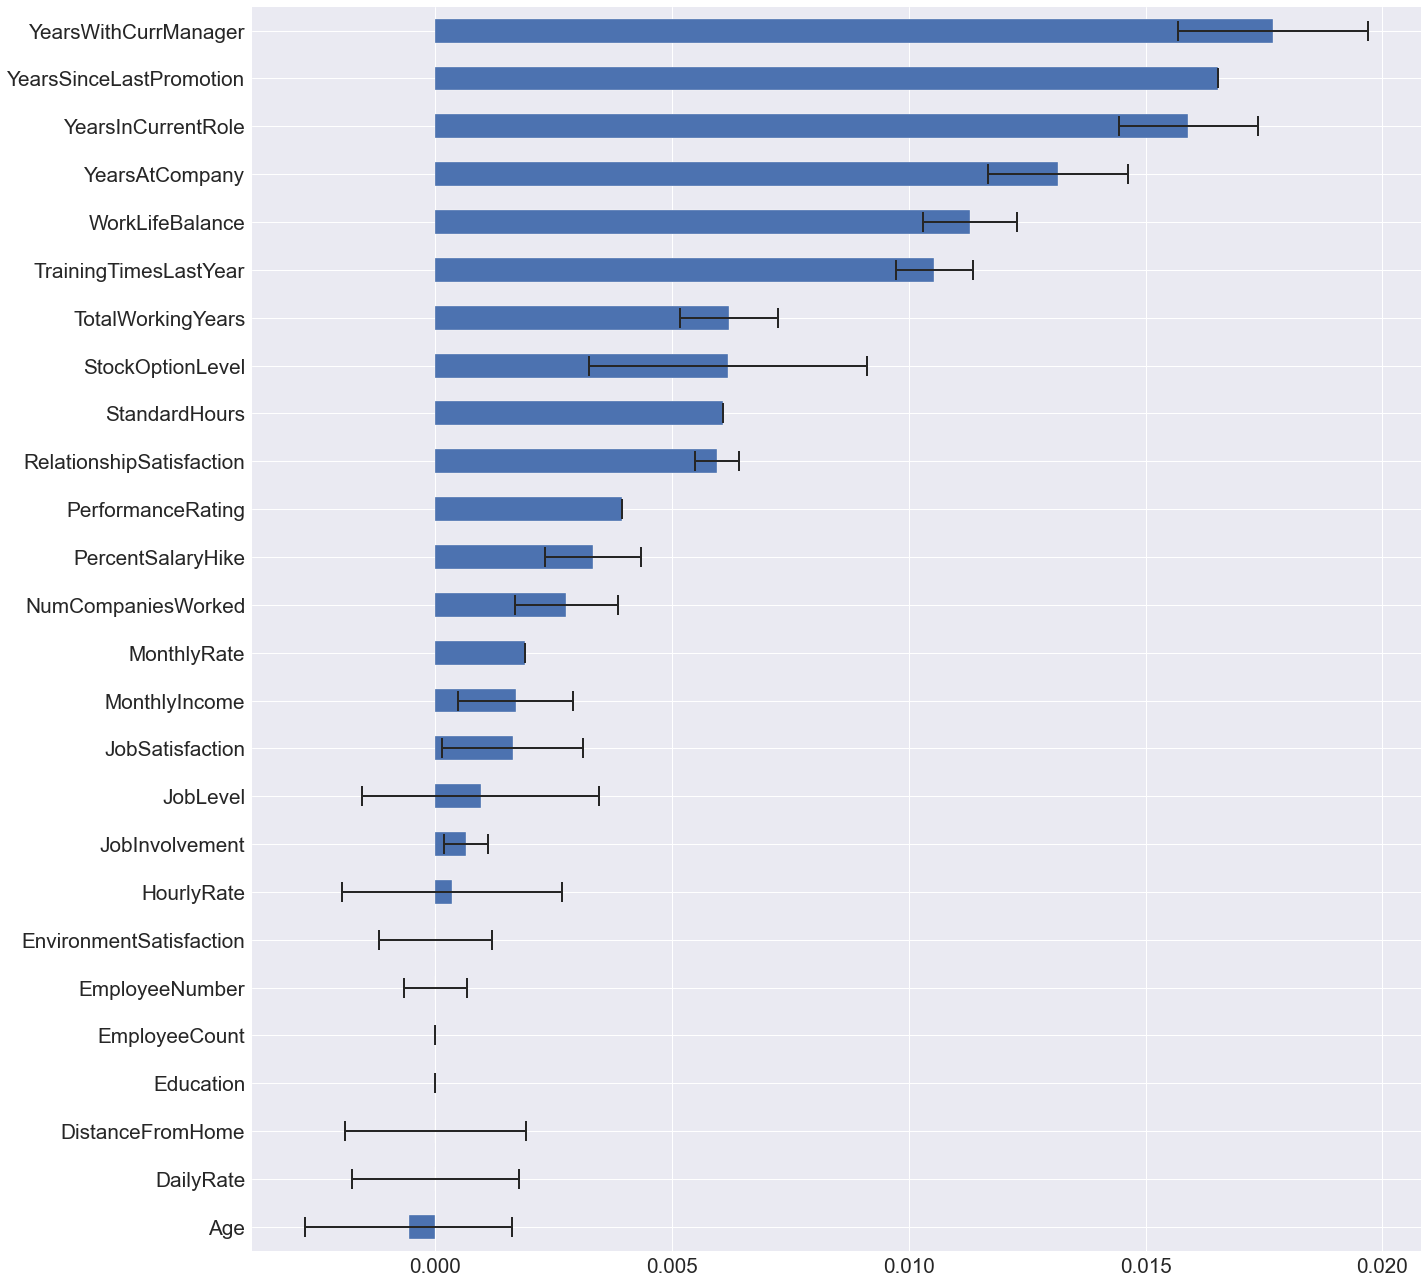

In [142]:
fig, ax = plt.subplots(figsize=(20,18))
features_importance.plot.barh(xerr=importances.importances_std, ax=ax,
                             error_kw={'elinewidth': 2, 'capsize': 10, 'capthick': 2})
ax.tick_params(labelsize='xx-large')
fig.tight_layout()
plt.show()

Esta análise, apesar de tomar apenas dados numéricos, excluindo os categóricos, possibilita que entendemos quais categóricos possivelmente podem ser utilizados para melhorar a análise.

Mas antes de partimos para a análise de dados categóricos, faremos um estudo mais aproximado sobre as variáveis acima. 

### Um olhar sobre as variáveis mais improtantes

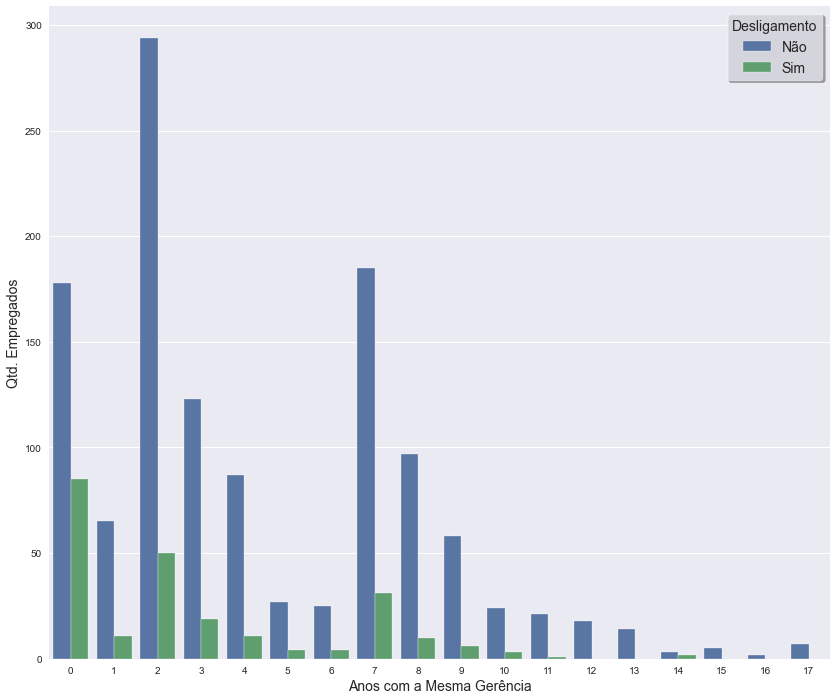

In [143]:
figs, axs = plt.subplots(figsize=(14,12), nrows=1, ncols=1, squeeze=False)
sns.countplot(x=data.YearsWithCurrManager, hue=data.Attrition)
plt.xlabel('Anos com a Mesma Gerência', fontsize=14) 
plt.ylabel('Qtd. Empregados', fontsize=14)
plt.legend(["Não", "Sim"], loc='upper right', fontsize=14, title='Desligamento', title_fontsize=14, 
frameon=True, framealpha=0.75, edgecolor='white', fancybox=True, shadow=True)
plt.show()

No gráfico de barras acima, é construída a relação entre a variável número de anos com o atual gerente e a variável alvo.  Podemos verificar melhor essa relação plotando a densidade de funcionários perdidos pelo número de anos com o atual gerente.

In [179]:
def binary_cumulative(data_frame: pd.DataFrame, variavel_explicativa: str,
 variavel_alvo: str, sorted: bool = False) -> Dict[Any, List]:
  
  """
  Função que calcula, para uma variável alvo binária, a quantidade de ocorrências de \n
  cada valor da variável alvo, em cada valor da variável explicativa.


  Parametros
  ----------
  data_frame : pd.DataFrame
      DataFrame com as variáveis explicativas e alvo.
  variavel_explicativa : str
      Nome da variável explicativa.
  variavel_alvo : str
      Nome da variável alvo.
  sorted : bool, optional
      Se True, retorna uma lista ordenada.
  
  Retorno
  -------
  Retorna um dicionário com as ocorrências dos valores da variável alvo \n
  para cada valor da variável explicativa.

  Exemplo
  -------
  >>> binary_cumulative(data_frame, "Attrition", "YearsWithCurrManager")
  >>> {5: [27, 4],
  >>> 7: [185, 31],
  >>> 0: [178, 85],
  >>> 2: [294, 50],
  >>> 6: [25, 4],
  >>> 8: [97, 10],
  >>> 3: [123, 19],
  >>> 11: [21, 1],
  >>> 17: [7, 0],
  >>> 1: [65, 11],
  >>> 4: [87, 11],
  >>> 12: [18, 0],
  >>> 9: [58, 6],
  >>> 10: [24, 3],
  >>> 15: [5, 0],
  >>> 13: [14, 0],
  >>> 16: [2, 0],
  >>> 14: [3, 2]}

  """

  # ------------------------------------------------------------ #
  
  # Inicializando o dicionário que armazenará os resultados
  dict_result = {}

  # ------------------------------------------------------------ #

  # Armazenando em um array os valores únicos da variavel explicativa
  if sorted:
    data_feature_unique_values = np.sort(data_frame[variavel_explicativa].unique())
  else:
    data_feature_unique_values = data_frame[variavel_explicativa].unique()

  # ------------------------------------------------------------ #

  # Armazenando os valores únicos da variavel alvo
  binary_target = np.sort(data_frame[variavel_alvo].unique())

    # Criando uma tupla para abrigar os valores da variável alvo
  binary_values_target = (binary_target[0], binary_target[1])

  # ------------------------------------------------------------ #


  # Loop para calcular a ocorrência dos valores binários da variável alvo, em cada valor da variável explicativa

  for i in data_feature_unique_values:
    dict_result[i] = [data_frame.loc[(data_frame[variavel_alvo]==binary_values_target[0]) & (data_frame[variavel_explicativa]==i)].__len__(),
                           data_frame.loc[(data_frame[variavel_alvo]==binary_values_target[1]) & (data_frame[variavel_explicativa]==i)].__len__()] 

  # ------------------------------------------------------------ #

  # Retornando um dicionário com os resultados {variável explicativa: (ocorrencias da variavel alvo 1, ocorrencias da variavel alvo 2)}
  return dict_result 

In [181]:
def to_plot_cumulative(data_frame: pd.DataFrame, variavel_explicativa: str, 
  variavel_alvo: str, index: int) -> Tuple[float]:
  """
  Função que gera dados prontos para plot, considerando o agregado dos valores binários\n
  para cada valor da variável explicativa.

    Parametros
    ----------
    data_frame : pd.DataFrame
        DataFrame com as variáveis explicativas e alvo.
    variavel_explicativa : str
        Nome da variável explicativa.
    variavel_alvo : str
        Nome da variável alvo.
    index : int
        Índice que específica qual valor da variável alvo a ser utilizado.

    Retorno
    -------
    list_key: float
        Lista com os valores da variável explicativa.
    list_value: float
        Lista com o valor cumulativo da variável alvo escolhida.


    Exemplo
    -------
    >>> to_plot_cumulative(data_frame, "Attrition", "YearsWithCurrManager", 0)
    >>> ([5, 7, 0, 2, 6, 8, 3, 11, 17, 1, 4, 12, 9, 10, 15, 13, 16, 14],
     [27, 185, 178, 294, 25, 97, 123, 21, 65, 87, 58, 24, 5, 14, 2, 3, 0, 0, 0])
  """

  # ------------------------------------------------------------ #

  # Iniciando as listas que serão utilizadas para armazenar os dados
  list_key = []
  list_values = []

  # ------------------------------------------------------------ #

  # Gerando o dicionário com os resultados da função binary_cumulative
  dict_result = binary_cumulative(data_frame, variavel_explicativa, variavel_alvo)

  # ------------------------------------------------------------ #

  # Loop para desempacotar o dicionário de resultados
  for i, j in zip(dict_result.keys(), dict_result.values()):
    list_key.append(i)
    list_values.append(j[index])
  

  # ------------------------------------------------------------ #

  # Retornando uma tupla com os dados prontos para plot
  return list_key, list_values

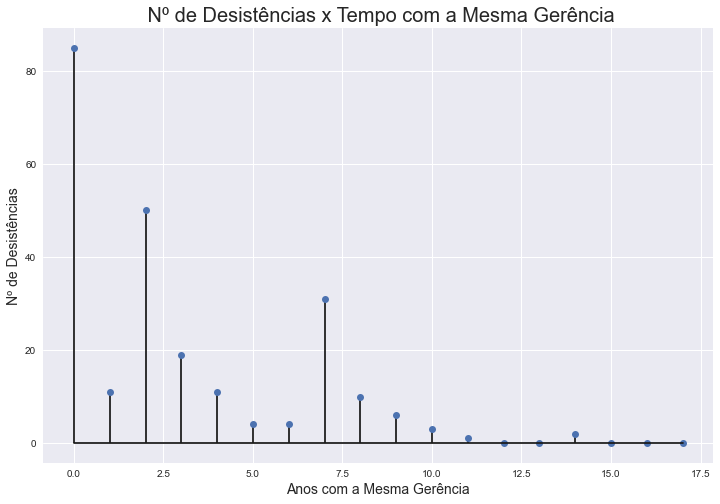

In [146]:
x, y  = to_plot_cumulative(data, "YearsWithCurrManager", "Attrition", 1)
plt.stem(x, y, markerfmt='bo', basefmt='k-', linefmt='k-')
plt.title(" Nº de Desistências x Tempo com a Mesma Gerência", fontsize=20)
plt.xlabel("Anos com a Mesma Gerência", fontsize=14)
plt.ylabel("Nº de Desistências", fontsize=14)
plt.show()

O gráfico acima pode indicar que a troca de gerência pode ocasionar em uma tendência de perda de funcionários e até uma predileção dos funcionários por ambientes de maior estabilidade. Pois tenha vista que a troca de uma gerência pode impactar muito no dia-a-dia dos funcionários de uma empresa. Logo, se uma empresa troca de gerência muitas vezes, pode se esperar que o ambiente de trabalho seja mais instável, com mais mudanças de estruturação.

Podemos investigar outros atributos que podem informar um pouco mais sobre essa tendência. Por exmeplo, podemos verificar como os anos na empresa são correlacionados com a quantidade de funcionários perdidos.

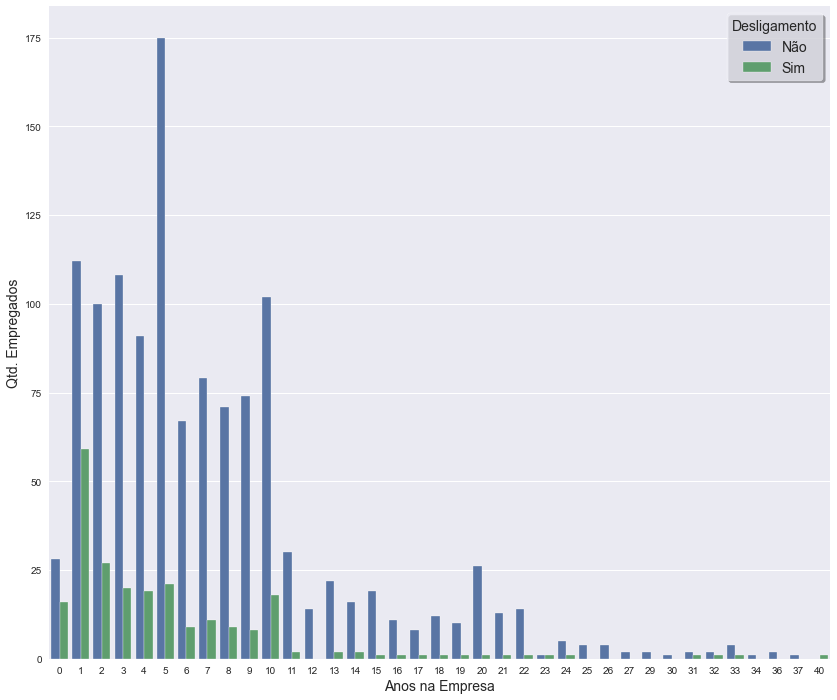

In [147]:
figs, axs = plt.subplots(figsize=(14,12), nrows=1, ncols=1, squeeze=False)
sns.countplot(x=data.YearsAtCompany, hue=data.Attrition)
plt.xlabel('Anos na Empresa', fontsize=14) 
plt.ylabel('Qtd. Empregados', fontsize=14)
plt.legend(["Não", "Sim"], loc='upper right', fontsize=14, title='Desligamento', title_fontsize=14, 
frameon=True, framealpha=0.75, edgecolor='white', fancybox=True, shadow=True)
plt.show()

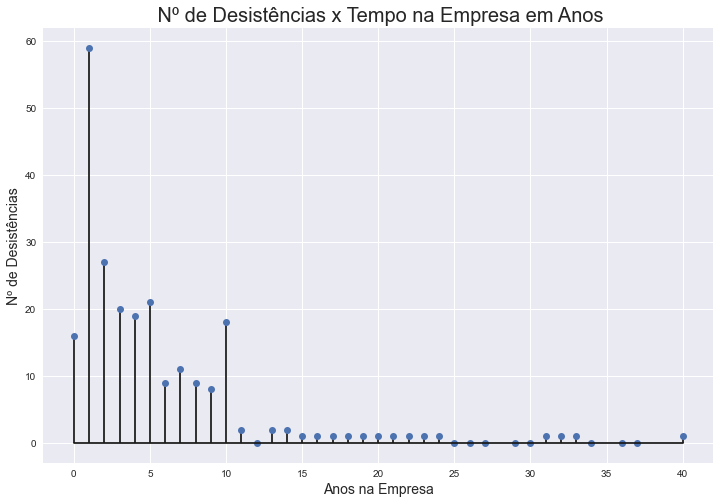

In [148]:
x, y  = to_plot_cumulative(data, "YearsAtCompany", "Attrition", 1)
plt.stem(x, y, markerfmt='bo', basefmt='k-', linefmt='k-')
plt.title(" Nº de Desistências x Tempo na Empresa em Anos", fontsize=20)
plt.xlabel("Anos na Empresa", fontsize=14)
plt.ylabel("Nº de Desistências", fontsize=14)
plt.show()

E também os anos desde a última promoção que o empregado recebeu.

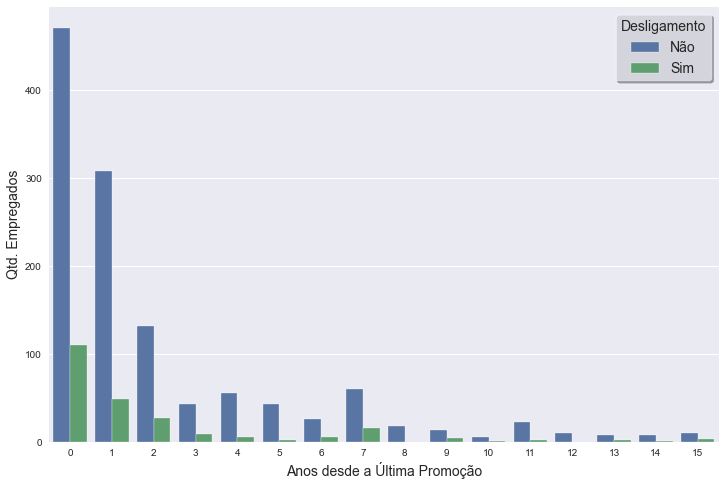

In [149]:
# figs, axs = plt.subplots(figsize=(14,12), nrows=1, ncols=1, squeeze=False)
sns.countplot(x=data.YearsSinceLastPromotion, hue=data.Attrition)
plt.xlabel('Anos desde a Última Promoção', fontsize=14) 
plt.ylabel('Qtd. Empregados', fontsize=14)
plt.legend(["Não", "Sim"], loc='upper right', fontsize=14, title='Desligamento', title_fontsize=14, 
frameon=True, framealpha=0.75, edgecolor='white', fancybox=True, shadow=True)
plt.show()

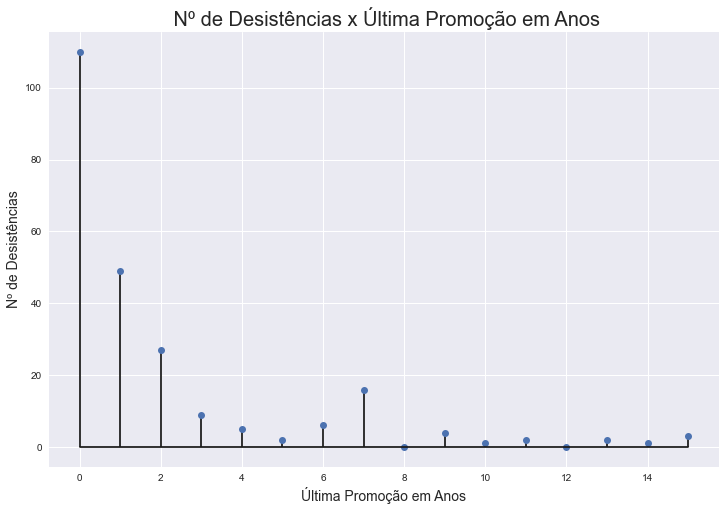

In [150]:
x, y  = to_plot_cumulative(data, "YearsSinceLastPromotion", "Attrition", 1)
plt.stem(x, y, markerfmt='bo', basefmt='k-', linefmt='k-')
plt.title(" Nº de Desistências x Última Promoção em Anos", fontsize=20)
plt.xlabel("Última Promoção em Anos", fontsize=14)
plt.ylabel("Nº de Desistências", fontsize=14)
plt.show()

Sendo esse último bastante contraintuitivo, pois esses dados poderiam levar à conclusão de que promover um funcionário aumentariam as chances desse abandonar a empresa. Porém, devemos fazer essa análise com bastante cautela. Isso porque podemos verificar que a distribuição de funcionários nesses atributos já seguem uma distribuição de cauda-longa, independentemente se ocorreu o *attrition* ou não. 

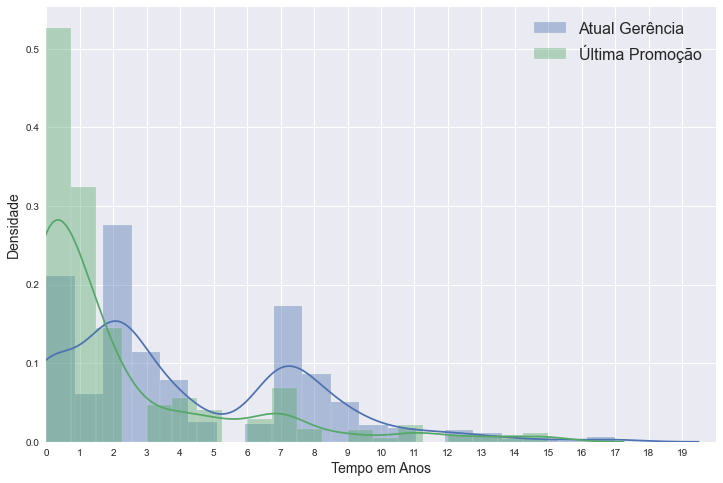

In [199]:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,8))
sns.distplot(data.YearsWithCurrManager, bins=20, kde=True, label='Atual Gerência')
sns.distplot(data.YearsSinceLastPromotion, bins=20, kde=True, label='Última Promoção')
ticks_x = np.arange(0, 20, 1)
plt.xticks(ticks_x)
plt.xlim(0, 20)
plt.xlabel('Tempo em Anos', fontsize=14)
plt.ylabel('Densidade', fontsize=14)
plt.legend(fontsize=16)
plt.show()

Como pensado, a distribuição vai afunilando com o passar dos anos. Portanto, devemos verificar se a nossa hipótese tem consistência estatística para ser afirmada.

In [185]:
def get_proportion(data_frame: pd.DataFrame, variavel_explicativa: str,
  variavel_alvo: str) -> List[float]:
  """
  Dada a variável explicativa e a variável alvo de um determinado dataset, \n
  retorna uma lista que gera a razão dos valores totais de cada valor da variável\n
  alvo para cada valor da variável explicativa.

  Parâmetros
  ----------
  data_frame : pd.DataFrame
      DataFrame que contém os dados.
  variavel_explicativa : str
      Nome da variável explicativa.
  variavel_alvo : str
      Nome da variável alvo.
  
  Retorno
  -------
  proportion_value : list
      Lista com a razão dos valores totais de cada valor da variável alvo para\n
      cada valor da variável explicativa.
  
  Notas 
  -----
  Considerando que para um valor $x$ de uma variável explicativa haverão \n
  $y_{0}$ exemplos de funcionários com $attrition=0$ e $y_{1}$ com $attrition=1$.\n
  A proporção usada no nosso cálculo é:
  $proportion = y_{1}/y_{0}.$
  Sendo assim, um aumento na proporção indica um aumento nos valores de $attrition=1$.\n
  E uma redução, indica um aumento na proporção de valores de $attrition=0$.

  Exemplo
  -------
  >>> get_proportion(data, "YearsWithCurrManager", "Attrition")
  >>> [0.14814814814814814,
  >>> 0.16756756756756758,
  >>> 0.47752808988764045,
  >>> 0.17006802721088435,
  >>> 0.16,
  >>> 0.10309278350515463,
  >>> 0.15447154471544716,
  >>> 0.047619047619047616,
  >>> 0.0,
  >>> 0.16923076923076924,
  >>> 0.12643678160919541,
  >>> 0.0,
  >>> 0.10344827586206896,
  >>> 0.125,
  >>> 0.0,
  >>> 0.0,
  >>> 0.0,
  >>> 0.6666666666666666]
  """

  # ------------------------------------------------------------ #

  proportion_list = []
  x_0, y_0 = to_plot_cumulative(data_frame, variavel_explicativa, variavel_alvo, 0)
  x_1, y_1 = to_plot_cumulative(data_frame, variavel_explicativa, variavel_alvo, 1)

  # ------------------------------------------------------------ #

  
  proportion_list = [ y1/y0 for y0,y1 in zip(y_0, y_1) if y0 != 0]

  return proportion_list

In [182]:
get_proportion(data, "YearsWithCurrManager", "Attrition")

[0.14814814814814814,
 0.16756756756756758,
 0.47752808988764045,
 0.17006802721088435,
 0.16,
 0.10309278350515463,
 0.15447154471544716,
 0.047619047619047616,
 0.0,
 0.16923076923076924,
 0.12643678160919541,
 0.0,
 0.10344827586206896,
 0.125,
 0.0,
 0.0,
 0.0,
 0.6666666666666666]

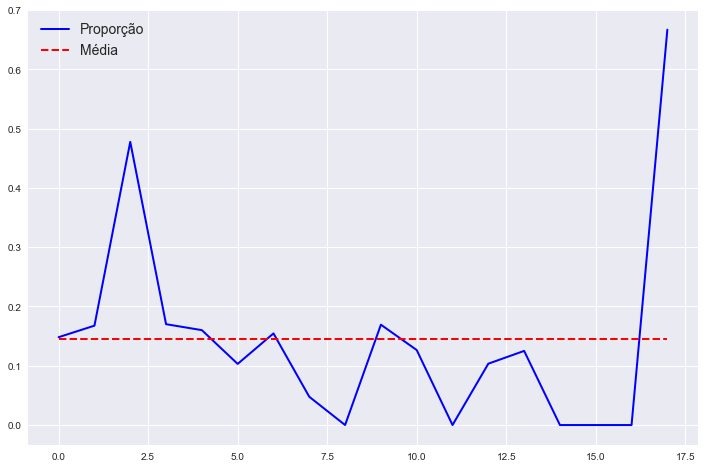

In [153]:
list_plot = get_proportion(data, "YearsWithCurrManager", "Attrition")

mean_plot = [np.mean(list_plot) for x in range(len(list_plot))]

plt.plot(list_plot, color='blue', linewidth=2, label='Proporção')
plt.plot(mean_plot, color='red', linewidth=2, linestyle='--', label='Média')
plt.legend(loc='best', fontsize=14)
plt.show()

proportion = y1/y0
y0 -> attrition 0
y1 -> attrition 1


Se com a passagem do tempo a proportion aumenta, então significa que, pra um determinado atributo, quanto mais o tempo passa, maior as chances do funcionário abandonar a empresa.

Se com a passagem do tempo a proportion diminui, então significa que, pra um determinado atributo, quanto mais o temp opassa, menor as chances do funcionário abandonar a empresa.

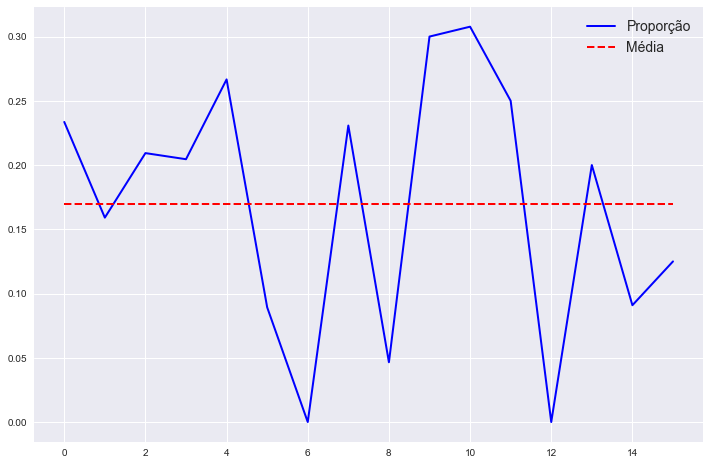

In [154]:
list_plot = get_proportion(data, "YearsSinceLastPromotion", "Attrition")

mean_plot = [np.mean(list_plot) for x in range(len(list_plot))]

plt.plot(list_plot, color='blue', linewidth=2, label='Proporção')
plt.plot(mean_plot, color='red', linewidth=2, linestyle='--', label='Média')
plt.legend(loc='best', fontsize=14)
plt.show()

In [155]:
coef, p = kendalltau(list_plot, [x for x in range(len(list_plot))])
print(f"O Coeficiente de Correlação de Kendall é: {coef}\n")
print(f"O p-value de Kendall é: {p}\n")

O Coeficiente de Correlação de Kendall é: -0.10878756313824399

O p-value de Kendall é: 0.557951571546442



A partir do p-valor calculado acima, podemos aceitar a hipótese nula de que os anos desde a última promoção não influência na perda de funcionários.

In [176]:
def get_correlation_time(data_frame: pd.DataFrame, variavel_explicativa: str,
variavel_alvo: str) -> Tuple[float]:
  """
  Para variáveis que variam com o tempo, indica se a variável alvo possui\n
  correlação com a variável no tempo. Retorna uma lista com o coeficiente de\n
  correlação e o p-valor de Kendall.

    Parametros
    ----------
    - data_frame: DataFrame com os dados.
    - variavel_explicativa: Variável explicativa.\n
    - variavel_alvo: Variável alvo.\n

    Retorno
    -------
    - Coeficiente de correlação de Kendall: float \n
    - p-valor de Kendall: float \n

    Exemplo
    -------
    >>> get_correlation_time(data, "YearsWithCurrManager", "Attrition")
    >>> (0.948, 0.0012)
  """

  # ------------------------------------------------------------ #

  proportion_list = get_proportion(data_frame, variavel_explicativa, variavel_alvo)
  coef, p_value = kendalltau(proportion_list, [x for x in range(len(proportion_list))])

  # ------------------------------------------------------------ #

  return coef, p_value



def test_null_result(data_frame: pd.DataFrame, variavel_explicativa: str, variavel_alvo: str) -> None:
  """
  Considerando que a hipótese nula é que a passagem do tempo não influência linearmente\n
  a variável alvo. Gera um resultado no console indicando se a hipótese nula\n
  foi aceita ou não.
    Parametros
    ----------
    - data_frame: DataFrame com os dados.
    - variavel_explicativa: Variável explicativa.\n
    - variavel_alvo: Variável alvo.\n

    Retorno
    -------
    - Realiza o teste e indica se a hipótese nula foi aceita ou não.

  """

  # ------------------------------------------------------------ #

  coef, p_valor = get_correlation_time(data_frame, variavel_explicativa, variavel_alvo)

  if (p_valor > 0.05) or (coef == 0.0):
    print(
    f"Considerando {variavel_explicativa}, a passagem do tempo não influencia no Attrition. \n nível de significância: 5% \n p-valor: {round(p_valor, 4)}"
    )

  else:
    if coef>0:
      print(f"Considerando {variavel_explicativa}, a passagem do tempo aumenta as chances do empregado abandonar a empresa com nível de significância de 5%. \n Coeficiente de correlação: {round(coef, 4)} \n p-valor: {round(p_valor, 4)}")
    
    elif coef<0:
      print(f"Considerando {variavel_explicativa}, a passagem do tempo diminui as chances do empregado abandonar a empresa com nível de significância de 5%. \n Coeficiente de correlação: {round(coef, 4)} \n p-valor: {round(p_valor, 4)}")


  

Com uma função construída para obter os resultados rapidamente, podemos checar se há uma relação com as demais variáveis que possuem o mesmo perfil. Por exemplo, será se o tempo que o funcionário passa com o mesmo gerente influencia na permanência dele na empresa?

In [157]:
test_null_result(data, "YearsWithCurrManager", "Attrition")

Considerando YearsWithCurrManager, a passagem do tempo diminui as chances do empregado abandonar a empresa com nível de significância de 5%. 
 Coeficiente de correlação: -0.3718 
 p-valor: 0.035


Façamos também com o tempo desde a última promoção do empregado e também o tempo que o empregado está na empresa.

In [158]:
test_null_result(data, "YearsSinceLastPromotion", "Attrition")

print()
print("#" + 90*"-" + "#")
print()

test_null_result(data, "YearsAtCompany", "Attrition")

Considerando YearsSinceLastPromotion, a passagem do tempo não influencia no Attrition. 
 nível de significância: 5% 
 p-valor: 0.558

#------------------------------------------------------------------------------------------#

Considerando YearsAtCompany, a passagem do tempo não influencia no Attrition. 
 nível de significância: 5% 
 p-valor: 0.0527


Como podemos ver, entre os casos que visualizamos rapidamente, apenas o tempo que o funcionário passa com o mesmo gerente influencia de maneira progressiva se o funcionário irá continuar ou abandonar a empresa. Ou seja, se você pretende trocar o gerente da sua empresa, caso nenhuma política de contenção seja criada, você deve esperar um aumento na taxa de attrition nos dois anos, como podemos verificar no gráfico abaixo.

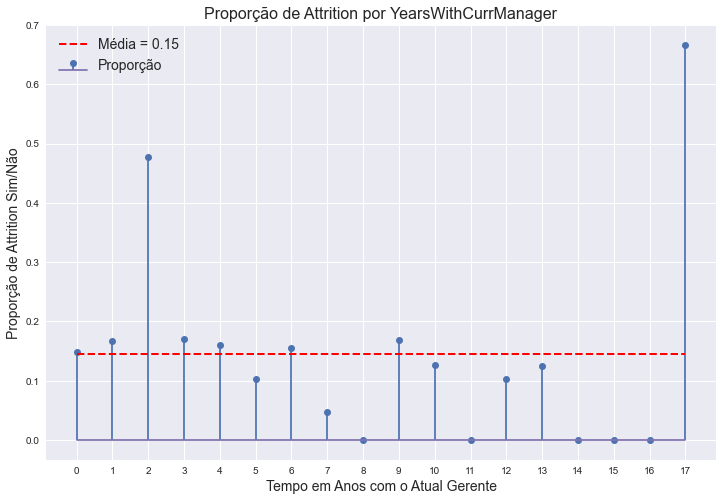

In [159]:
# Dados

list_plot = get_proportion(data, "YearsWithCurrManager", "Attrition")
mean_plot = [np.mean(list_plot) for x in range(len(list_plot))]
xticks = [x for x in range(len(list_plot))]


# Plot

plt.stem(list_plot, label='Proporção')
plt.plot(mean_plot, color='red', linewidth=2, linestyle='--', label=f'Média = {round(mean_plot[0], 2)}')

plt.xticks(xticks)
plt.ylabel("Proporção de Attrition Sim/Não", fontsize=14)
plt.xlabel('Tempo em Anos com o Atual Gerente', fontsize=14)

plt.legend(loc='best', fontsize=14)
plt.title("Proporção de Attrition por YearsWithCurrManager", fontsize=16)

plt.show()

Outro ponto que pode ser observado dos resultados acima é que podemos combinar as variáveis YearsAtCompany com as demais variáveis que descrevem alguma característica ao longo dos anos do empregado, como por exemplo, se combinarmos YearsAtCompany com YearsWithCurrManager, podemos verificar se aquele empregado já presenciou a mudança de gerente pelo menos uma vez ao longo do seu tempo na empresa. 

In [160]:
data_copy = deepcopy(data)
data_copy[["YearsAtCompany", "YearsWithCurrManager", "Attrition"]]

,YearsAtCompany,YearsWithCurrManager,Attrition
0,6,5,1
1,10,7,0
2,0,0,1
3,8,0,0
4,2,2,0
...,...,...,...
1465,5,3,0
1466,7,7,0
1467,6,3,0
1468,9,8,0


A construção do novo atributo ocorrerá ao comparar os anos na empresa com os anos com o atual gerente. Caso o número de anos seja o mesmo, saberemos que o empregado nunca presenciou a mudança de gerente, caso contrário, saberemos que o empregado já presenciou tal mudança.

In [246]:
data.loc[data_copy["YearsAtCompany"] == data["YearsWithCurrManager"], "WitnessedChangeManager"] = 0
data.loc[data["YearsAtCompany"] != data["YearsWithCurrManager"], "WitnessedChangeManager"] = 1
data = data.astype({"WitnessedChangeManager": int})

Agora vamos analisar como a nova variável está posta.

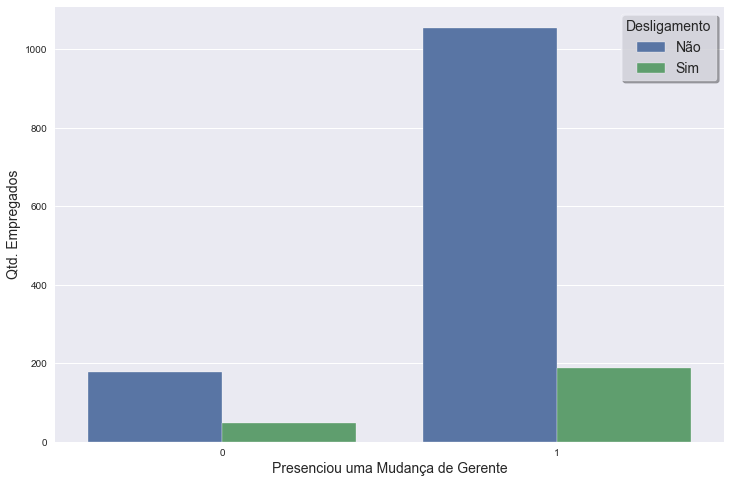

In [247]:
# figs, axs = plt.subplots(figsize=(14,12), nrows=1, ncols=1, squeeze=False)
sns.countplot(x=data.WitnessedChangeManager, hue=data.Attrition)
plt.xlabel('Presenciou uma Mudança de Gerente', fontsize=14) 
plt.ylabel('Qtd. Empregados', fontsize=14)
plt.legend(["Não", "Sim"], loc='upper right', fontsize=14, title='Desligamento', title_fontsize=14, 
frameon=True, framealpha=0.75, edgecolor='white', fancybox=True, shadow=True)
plt.show()

Podemos verificar como está a proporção de funcionários perdidos ou não, considerando se os funcionários passaram por um processo de mudança na gerência ou não.

In [248]:
nao_presenciou, presenciou = get_proportion(data, "WitnessedChangeManager", "Attrition")

print(f"A proporção de attrition de funcionários que presenciaram uma troca de gerência é: {round(presenciou, 2)}")
print(f"A proporção de attrition de funcionários que não presenciaram uma troca de gerência é: {round(nao_presenciou, 2)}")
print(f"A diferença da proporção entre os que presenciaram e não-presenciaram está na ordem de {round((presenciou-nao_presenciou)/presenciou*100, 2)}%")

A proporção de attrition de funcionários que presenciaram uma troca de gerência é: 0.27
A proporção de attrition de funcionários que não presenciaram uma troca de gerência é: 0.18
A diferença da proporção entre os que presenciaram e não-presenciaram está na ordem de 33.57%


Uma proporção maior, indica que houve uma quantidade maior de funcionários que se demitiram em uma amostra do que em outra. A proporção de funcionários que presenciaram a troca de gerência que abandonaram a empresa aumentou em 33.57% em relação aos que não-presenciaram.

A hipótese inicial indicava que os funcionários possuiam uma predileção por ambientes de maior estabilidade, portanto, qualquer mudança brusca na dinâmica de trabalho de um funcionário poderia aumentar as chances deste se desligar da empresa. Apesar da hipótese se mostrar infundada para algumas variáveis, como o tempo desde a última promoção do funcionário, ela apresentou robustez para a variável que indica o tempo que o funcionário se encontra com a atual gerência. Esse resultado nos permitiu a criação de um novo atributo, que se compromete em assimilar se um dado funcionário presenciou, no seu tempo de empresa, uma troca de gerência ou não, chegando a conclusão de que funcionários que presenciaram tal troca, possuem uma maior probabilidade de se desligarem da empresa.

Uma sugestão inicial que poderíamos realizar a partir da análise desses dados é de que caso seja necessária a troca da atual gerência, ou de alguma política que impacte consideravelmente a dinâmica da empresa, que um plano de contingência seja estabelecido de modo a reduzir o impacto da mudança e também novos planos de incentivo sejam discutidos durante o tempo de adaptação dos funcionários ao novo cenário.

### Um olhar sobre as variáveis menos importantes

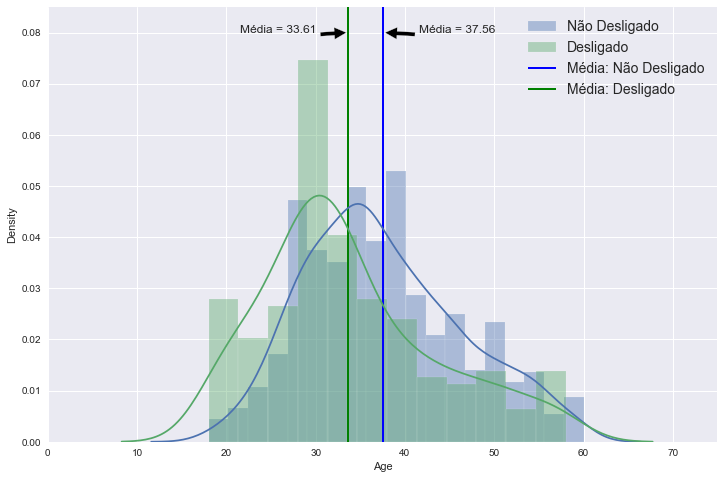

In [242]:
data_age_att_0 = data.loc[data["Attrition"] == 0, "Age"]
data_age_att_1 = data.loc[data["Attrition"] == 1, "Age"]
sns.distplot(data_age_att_0, kde=True, label="Não Desligado")
sns.distplot(data_age_att_1, kde=True, label="Desligado")
plt.vlines(x=data_age_att_0.mean(), ymin=0, ymax=0.09, linestyles='solid', linewidth=2, color='blue', label="Média: Não Desligado")
plt.vlines(x=data_age_att_1.mean(), ymin=0, ymax=0.09, linestyles='solid', linewidth=2, color='green', label="Média: Desligado")
plt.annotate(f"Média = {round(data_age_att_0.mean(), 2)}" , xy=(data_age_att_0.mean(), 0.08), xytext=(data_age_att_0.mean()+4, 0.08), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f"Média = {round(data_age_att_1.mean(), 2)}" , xy=(data_age_att_1.mean(), 0.08), xytext=(data_age_att_0.mean()-16, 0.08), arrowprops=dict(facecolor='black', shrink=0.05))
plt.xlim(0, 75)
plt.ylim(0, 0.085)
plt.legend(fontsize=14)
plt.show()

Podemos ver duas distribuições relativamente semelhantes. Podemos realizar um teste Z para verificar se as duas distribuições são iguais.

In [206]:
_, p_valor = ztest(data.loc[data["Attrition"]==0, "Age"], data.loc[data["Attrition"]==1, "Age"], alternative="two-sided")

print(f"As distribuições de idade para funcionários que se desligaram e não se desligaram é diferente, de acordo com o p-valor: {p_valor}")

As distribuições de idade para funcionários que se desligaram e não se desligaram é diferente, de acordo com o p-valor: 6.464638013435308e-10


Este resultado pode indicar que há um tendência que funcionários mais novos se desliguem da empresa. Isso pode estar relacionado com a hipótese inicial, pois podem não ter passado tempo o suficiente na empresa para se estabelecer. Já funcionários mais antigos estão mais bem estabelecidos e familiarizados com as dinâmicas da empresa, sendo assim, possuindo uma maior probabilidade de permanecer na empresa.

## Preparação dos Dados

### Tratando os Atributos Categóricos

Para tratar os atributos categóricos, podemos investigar a natureza de cada atributo categórico. Primeiro, vamos listá-los.

In [262]:
data_categorical = data.select_dtypes(exclude=np.number)
data_categorical.columns

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')

In [269]:
data_categorical["OverTime"].unique()

array(['Yes', 'No'], dtype=object)

In [249]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   int32 
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [250]:
x = data.drop(columns=["Attrition"])
y = data[["Attrition"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=13)

In [252]:
lgbm_ = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.05, num_leaves=32,)

lgbm_.fit(x_train, y_train)

lgbm_.score(x_test, y_test)


C:\Users\Lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: BusinessTravel, Department, EducationField, Gender, JobRole, MaritalStatus, Over18, OverTime